# Import Libraries

In [1]:
#Import source code
from src import dynamicmodel as dm

import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

#Signal processing
from scipy import signal

# Open Data

Previously, signals were generated from the Dynamic Modeler and saved to csv files.

In this Notebook, the csv files are opened into Pandas DataFrames.

In [2]:
#Configure save paths
save_folder = "exports"
save_path = "{}\\{}\\".format(str(Path.cwd()), save_folder)

#Open signal data as DataFrames
df1 = pd.read_csv(save_path + 'x_dampeddriven.csv')

# Apply Filters

Here I use butterworth filters to split the signal into a "highpass" signal and "lowpass "signal, consisting of the higher and lower frequencies, respectively.

I try to use a high enough order number to approximate the effect of a perfect bandpass filter, where the freququency cutoffs are as sharp as possible.

In [3]:
#Initiate filters

#Set Butterworth filter order number
butter_N = 7

#Lowpass filter
lp = signal.butter(N=butter_N, Wn=.00008, btype='lowpass', fs=.01, output='sos')
#Highpass filter
hp = signal.butter(N=butter_N, Wn=.00008, btype='highpass', fs=.01, output='sos')

#Apply Lowpass filter
df1['x_lp'] = signal.sosfilt(lp, df1['x'])
#Apply Highpass filter
df1['x_hp'] = signal.sosfilt(hp, df1['x'])

In [4]:
np.shape(df1[['t', 'x_lp']].to_numpy())[1]

2

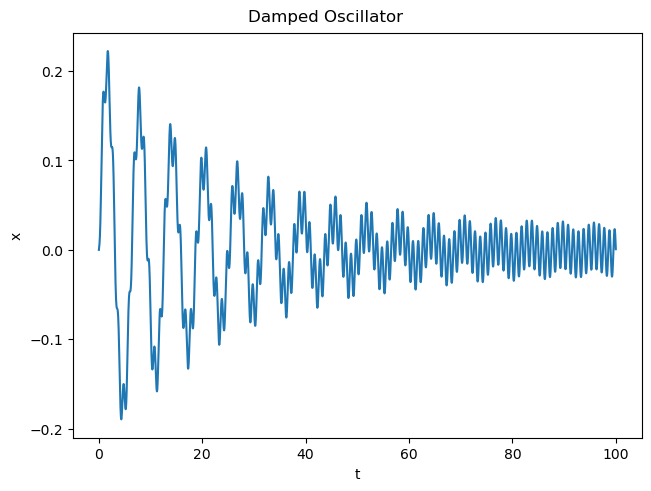

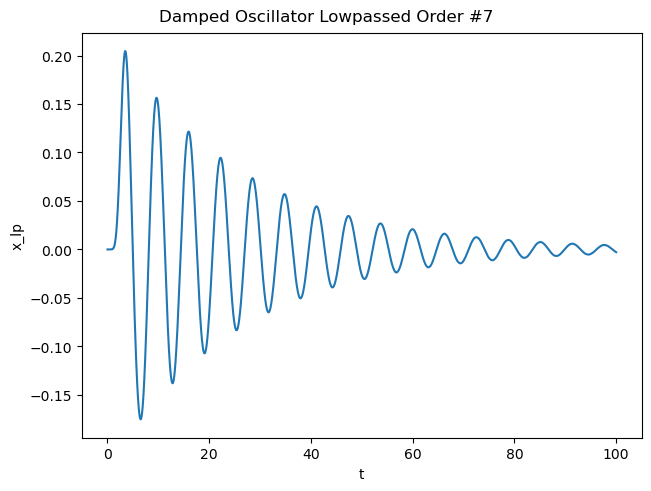

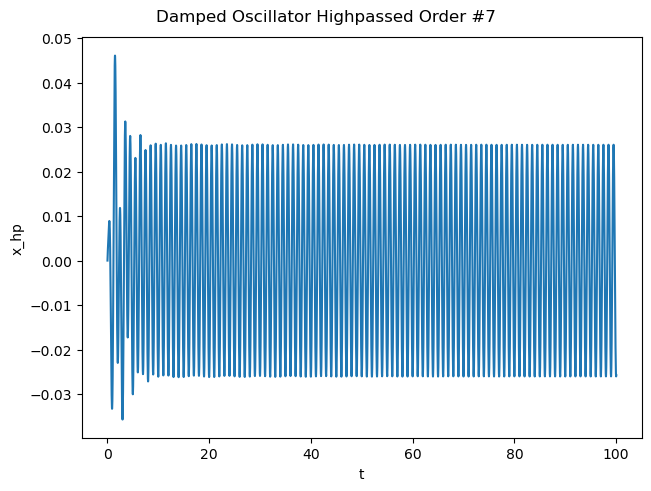

In [5]:
#Plot lowpassed and highpassed signals
dm.plot_df(df=df1[['t', 'x']], title='Damped Oscillator')
dm.plot_df(df=df1[['t', 'x_lp']], title='Damped Oscillator Lowpassed Order #{}'.format(str(butter_N)))
dm.plot_df(df=df1[['t', 'x_hp']], title='Damped Oscillator Highpassed Order #{}'.format(str(butter_N)))

# Extract Training Data

A one dimensional signal needs to be properly formatted into an input and an output i.e. "label" for an LSTM model to train on it.

I define a function called create_dataset. It generates an input array and output array per training data point, through a series of overlapping windows. 


In [6]:
#Split data into multiple signals (inputs and labels) using a rolling window
def create_dataset(data, n_window, n_predict):
    #initialize data lists
    data_x = []
    data_y = []
    #initialize data
    for n in range(0, len(data)-n_window-n_predict):
        
        #Get training data
        #Training Inputs
        x = data[n:n+n_window]
        #Training Labels
        y = data[n+n_window:n+n_window+n_predict]
        
        #append training data and label to final format
        data_x += [x]
        data_y += [y]
    #convert lists to array
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    return data_x, data_y

In [7]:
#Determine length of training data
len_train = 4000

#Apply window function to prepare training data
n_window=600
n_predict=1
#low passed damped oscillator data
x_train_lp, y_train_lp = create_dataset(data=df1['x_lp'].to_numpy()[0:len_train], n_window=n_window, n_predict=n_predict)
#high passed damped oscillator data
x_train_hp, y_train_hp = create_dataset(data=df1['x_hp'].to_numpy()[0:len_train], n_window=n_window, n_predict=n_predict)

In [8]:
#Reshape input to be [samples, time steps, features]
x_train_lp = np.expand_dims(x_train_lp, axis=1)
x_train_hp = np.expand_dims(x_train_hp, axis=1)
x_train_lp.shape

(3399, 1, 600)

# Initiate and Train Models

TensorFlow neural networks consisting of one LSTM layer are created and fitted to the training data.

In [9]:
def create_model(x_length, y_length):
    """
    Description: 
        Create an LSTM model with specific parameters

    Args:
        x_length: int, length of training inputs
        y_lenght: int, length of training outputs
    """
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=n_predict, input_shape=(x_length, y_length)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [10]:
#Determine model parameters
x_length = 1
epochs = 20
batch_size = 1

#Create neural networks as Tensorflow model objects
model_lp = create_model(x_length=x_length, y_length=n_window)
model_hp = create_model(x_length=x_length, y_length=n_window)
#Train Model
model_lp.fit(x_train_lp, y_train_lp, epochs=epochs, batch_size=batch_size, verbose=2)
model_hp.fit(x_train_hp, y_train_hp, epochs=epochs, batch_size=batch_size, verbose=2)



Epoch 1/20

3399/3399 - 4s - loss: 5.6631e-05 - 4s/epoch - 1ms/step
Epoch 2/20
3399/3399 - 3s - loss: 3.4271e-05 - 3s/epoch - 1ms/step
Epoch 3/20
3399/3399 - 3s - loss: 3.2180e-05 - 3s/epoch - 1ms/step
Epoch 4/20
3399/3399 - 4s - loss: 3.7457e-05 - 4s/epoch - 1ms/step
Epoch 5/20
3399/3399 - 4s - loss: 3.8528e-05 - 4s/epoch - 1ms/step
Epoch 6/20
3399/3399 - 3s - loss: 4.0298e-05 - 3s/epoch - 1ms/step
Epoch 7/20
3399/3399 - 4s - loss: 3.2639e-05 - 4s/epoch - 1ms/step
Epoch 8/20
3399/3399 - 3s - loss: 3.2998e-05 - 3s/epoch - 1ms/step
Epoch 9/20
3399/3399 - 3s - loss: 3.1624e-05 - 3s/epoch - 1ms/step
Epoch 10/20
3399/3399 - 3s - loss: 3.2267e-05 - 3s/epoch - 1ms/step
Epoch 11/20
3399/3399 - 4s - loss: 2.8651e-05 - 4s/epoch - 1ms/step
Epoch 12/20
3399/3399 - 3s - loss: 2.6752e-05 - 3s/epoch - 1ms/step
Epoch 13/20
3399/3399 - 4s - loss: 2.7469e-05 - 4s/epoch - 1ms/step
Epoch 14/20
3399/3399 - 3s - loss: 2.5253e-05 - 3s/epoch - 1ms/step
Epoch 15/20
3399/3399 - 3s - loss: 2.3269e-05 - 3s/epo

# Predict

The trained models are used to predict the outputs of the signals.

In [11]:
def predict(model, df, len_train, column_name):
    """
    Description:
        Make predictions from signals in dataframe df, using model
        
    Args:
        model: TensorFlow model

        df: pandas DataFrame

        len_train: int; the length of the training data

        column_name: str; name of the DataFrame column being predicted
    """
    
    #Iteratively make predictions using past predictions
    prediction_base = df[column_name].to_numpy()[0:len_train]
    list_prediction = []
    
    #iterate the same number of times as there is test data
    len_test = len(df[column_name]) - len_train
    for n in range(len_test):
    
        print('predicting timestep {} out of {}'.format(str(n), str(len_test)))
        #Make prediction
        prediction = model.predict(np.expand_dims(np.expand_dims(prediction_base[-1*n_window:], axis=0), axis=0))
    
        #Add prediction to prediction_base
        prediction_base=np.append(prediction_base, prediction[0])
        list_prediction+=[prediction[0]]
    
        #Add prediction to list of predictions
        list_prediction

    array_prediction = np.array(list_prediction)

    return model, array_prediction

In [12]:
#Make predictions
model_lp, array_prediction_lp = predict(model=model_lp, df=df1, len_train=len_train, column_name='x_lp')
model_hp, array_prediction_hp = predict(model=model_hp, df=df1, len_train=len_train, column_name='x_hp')

predicting timestep 0 out of 1001
1/1 [==============================] - 0s 331ms/step
predicting timestep 1 out of 1001
1/1 [==============================] - 0s 19ms/step
predicting timestep 2 out of 1001
1/1 [==============================] - 0s 18ms/step
predicting timestep 3 out of 1001
1/1 [==============================] - 0s 17ms/step
predicting timestep 4 out of 1001
1/1 [==============================] - 0s 18ms/step
predicting timestep 5 out of 1001
1/1 [==============================] - 0s 19ms/step
predicting timestep 6 out of 1001
1/1 [==============================] - 0s 20ms/step
predicting timestep 7 out of 1001
1/1 [==============================] - 0s 19ms/step
predicting timestep 8 out of 1001
1/1 [==============================] - 0s 18ms/step
predicting timestep 9 out of 1001
1/1 [==============================] - 0s 19ms/step
predicting timestep 10 out of 1001
1/1 [==============================] - 0s 20ms/step
predicting timestep 11 out of 1001
1/1 [============

In [13]:
#Add filtered predictions back together
array_prediction = array_prediction_lp + array_prediction_hp

# Plot Results

Below, the predictions of the model are plotted against the actual signal (including both the training data and the hold out "future signal")

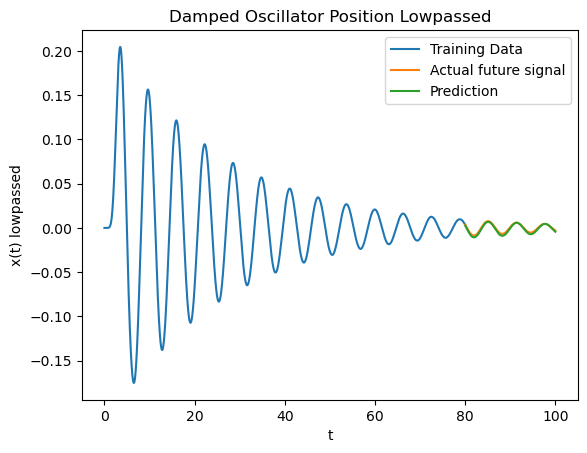

In [14]:
#Plot the actual signal
fig = plt.figure()
plt.title('Damped Oscillator Position Lowpassed')
plt.xlabel('t')
plt.ylabel('x(t) lowpassed')
plt.plot(df1['t'][0:len_train], df1['x_lp'][0:len_train], label='Training Data')
plt.plot(df1['t'][-1*len(array_prediction_lp):], df1['x_lp'][-1*len(array_prediction_lp):], label='Actual future signal')
plt.plot(df1['t'][-1*len(array_prediction_lp):],array_prediction_lp, label='Prediction')
plt.legend(loc='upper right')

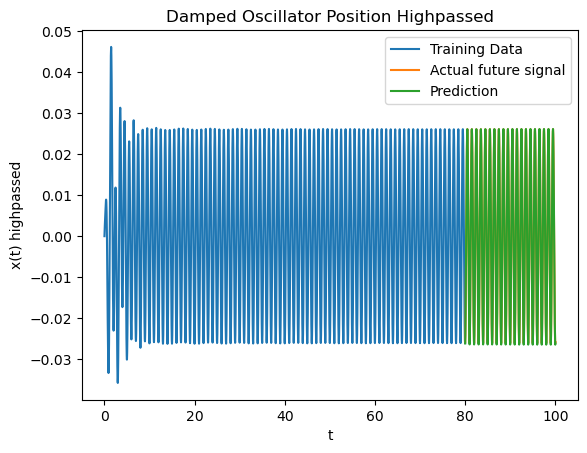

In [15]:
#Plot the actual signal
fig = plt.figure()
plt.title('Damped Oscillator Position Highpassed')
plt.xlabel('t')
plt.ylabel('x(t) highpassed')
plt.plot(df1['t'][0:len_train], df1['x_hp'][0:len_train], label='Training Data')
plt.plot(df1['t'][-1*len(array_prediction_hp):], df1['x_hp'][-1*len(array_prediction_hp):], label='Actual future signal')
plt.plot(df1['t'][-1*len(array_prediction_hp):],array_prediction_hp, label='Prediction')
plt.legend(loc='upper right')

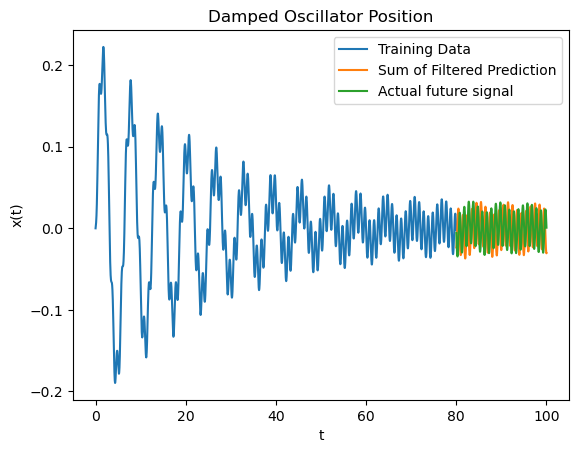

In [16]:
#Compare added filtered predictions
#Plot the actual signal
fig = plt.figure()
plt.title('Damped Oscillator Position')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.plot(df1['t'][0:len_train], df1['x'][0:len_train], label='Training Data')
plt.plot(df1['t'][-1*len(array_prediction):],array_prediction, label='Sum of Filtered Prediction')
plt.plot(df1['t'][-1*len(array_prediction):], df1['x'][-1*len(array_prediction):], label='Actual future signal')
plt.legend(loc='upper right')